<a href="https://colab.research.google.com/github/Sahel-Eskandar/Project-Notebooks/blob/main/7_ANFIS_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Sahel-Eskandar/TensorANFIS.git

Cloning into 'TensorANFIS'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 49 (delta 6), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (49/49), done.


In [ ]:
cd '/content/TensorANFIS'

/content/TensorANFIS


In [ ]:
!git pull 

Already up to date.


In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


In [ ]:
!cp /content/TensorANFIS/anfis.py .

cp: '/content/TensorANFIS/anfis.py' and './anfis.py' are the same file


In [ ]:
import anfis

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
from anfis import ANFIS

In [ ]:
class ANFIS:
    def __init__(self, n_inputs, n_rules, learning_rate=1e-2):
        self.n = n_inputs
        self.m = n_rules
        self.inputs = tf.placeholder(tf.float32, shape=(None, n_inputs))  # Input
        self.targets = tf.placeholder(tf.float32, shape=None)  # Desired output
        mu = tf.get_variable("mu", [n_rules * n_inputs],
                             initializer=tf.random_normal_initializer(0, 1))  # Means of Gaussian MFS
        sigma = tf.get_variable("sigma", [n_rules * n_inputs],
                                initializer=tf.random_normal_initializer(0, 1))  # Standard deviations of Gaussian MFS
        y = tf.get_variable("y", [1, n_rules], initializer=tf.random_normal_initializer(0, 1))  # Sequent centers

        self.params = tf.trainable_variables()

        self.rul = tf.reduce_prod(
            tf.reshape(tf.exp(-0.5 * tf.square(tf.subtract(tf.tile(self.inputs, (1, n_rules)), mu)) / tf.square(sigma)),
                       (-1, n_rules, n_inputs)), axis=2)  # Rule activations
        # Fuzzy base expansion function:
        num = tf.reduce_sum(tf.multiply(self.rul, y), axis=1)
        den = tf.clip_by_value(tf.reduce_sum(self.rul, axis=1), 1e-12, 1e12)
        self.out = tf.divide(num, den)

        self.loss = tf.losses.huber_loss(self.targets, self.out)  # Loss function computation
        # Other loss functions for regression, uncomment to try them:
        # loss = tf.sqrt(tf.losses.mean_squared_error(target, out))
        # loss = tf.losses.absolute_difference(target, out)
        self.optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)  # Optimization step
        # Other optimizers, uncomment to try them:
        # self.optimize = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(self.loss)
        # self.optimize = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(self.loss)
        self.init_variables = tf.global_variables_initializer()  # Variable initializer

    def infer(self, sess, x, targets=None):
        if targets is None:
            return sess.run(self.out, feed_dict={self.inputs: x})
        else:
            return sess.run([self.out, self.loss], feed_dict={self.inputs: x, self.targets: targets})

    def train(self, sess, x, targets):
        yp, l, _ = sess.run([self.out, self.loss, self.optimize], feed_dict={self.inputs: x, self.targets: targets})
        return l, yp

    def plotmfs(self, sess):
        mus = sess.run(self.params[0])
        mus = np.reshape(mus, (self.m, self.n))
        sigmas = sess.run(self.params[1])
        sigmas = np.reshape(sigmas, (self.m, self.n))
        y = sess.run(self.params[2])
        xn = np.linspace(-1.5, 1.5, 1000)
        for r in range(self.m):
            if r % 4 == 0:
                plt.figure(figsize=(11, 6), dpi=80)
            plt.subplot(2, 2, (r % 4) + 1)
            ax = plt.subplot(2, 2, (r % 4) + 1)
            ax.set_title("Rule %d, sequent center: %f" % ((r + 1), y[0, r]))
            for i in range(self.n):
                plt.plot(xn, np.exp(-0.5 * ((xn - mus[r, i]) ** 2) / (sigmas[r, i] ** 2)))


In [ ]:
# Mackey-Glass series computation
def mackey(n_iters):
    x = np.zeros((n_iters,))
    x[0:30] = 0.23 * np.ones((30,))
    t_s = 30
    for i in range(30, n_iters - 1):
        a = x[i]
        b = x[i - t_s]
        y = ((0.2 * b) / (1 + b ** 10)) + 0.9 * a
        x[i + 1] = y
    return x

In [ ]:
# Generate dataset
D = 4  # number of regressors
T = 1  # delay
N = 2000  # Number of points to generate
mg_series = mackey(N)[499:]  # Use last 1500 points
data = np.zeros((N - 500 - T - (D - 1) * T, D))
lbls = np.zeros((N - 500 - T - (D - 1) * T,))

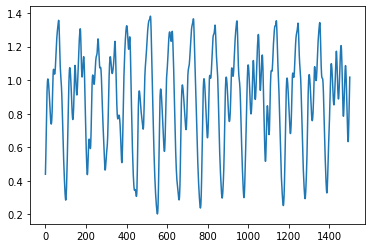

In [ ]:
plt.figure(1)
plt.plot(mg_series)
plt.show()

In [ ]:
for t in range((D - 1) * T, N - 500 - T):
    data[t - (D - 1) * T, :] = [mg_series[t - 3 * T], mg_series[t - 2 * T], mg_series[t - T], mg_series[t]]
    lbls[t - (D - 1) * T] = mg_series[t + T]
trnData = data[:lbls.size - round(lbls.size * 0.3), :]
trnLbls = lbls[:lbls.size - round(lbls.size * 0.3)]
chkData = data[lbls.size - round(lbls.size * 0.3):, :]
chkLbls = lbls[lbls.size - round(lbls.size * 0.3):]

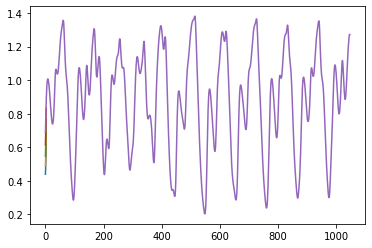

In [ ]:
plt.figure(1)
plt.plot(trnData[0])
plt.plot(trnData[1])
plt.plot(trnData[2])
plt.plot(trnData[3])
plt.plot(trnLbls)
plt.show()

In [ ]:
# ANFIS params and Tensorflow graph initialization
m = 16  # number of rules
alpha = 0.01  # learning rate

In [ ]:
fis = ANFIS(n_inputs=D, n_rules=m, learning_rate=alpha)

In [ ]:
fis.inputs

<tf.Tensor 'Placeholder:0' shape=(?, 4) dtype=float32>

Train cost after epoch 0: 1.102231
Train cost after epoch 10: 0.081611
Train cost after epoch 20: 0.010721
Train cost after epoch 30: 0.011641
Train cost after epoch 40: 0.004743
Train cost after epoch 50: 0.002671
Train cost after epoch 60: 0.002349
Train cost after epoch 70: 0.001906
Train cost after epoch 80: 0.001709
Train cost after epoch 90: 0.001561
Elapsed time: 0.841418
Validation loss: 0.001557


/content/TensorANFIS/anfis.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(2, 2, (r % 4) + 1)
/content/TensorANFIS/anfis.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(2, 2, (r % 4) + 1)
/content/TensorANFIS/anfis.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance w

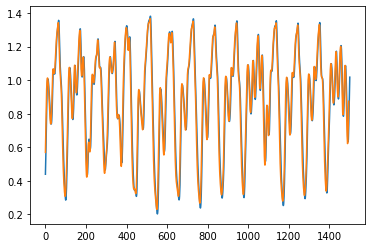

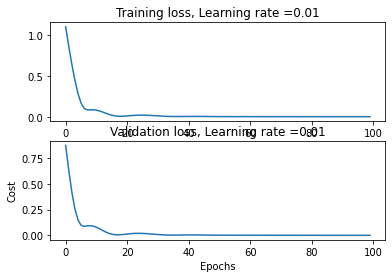

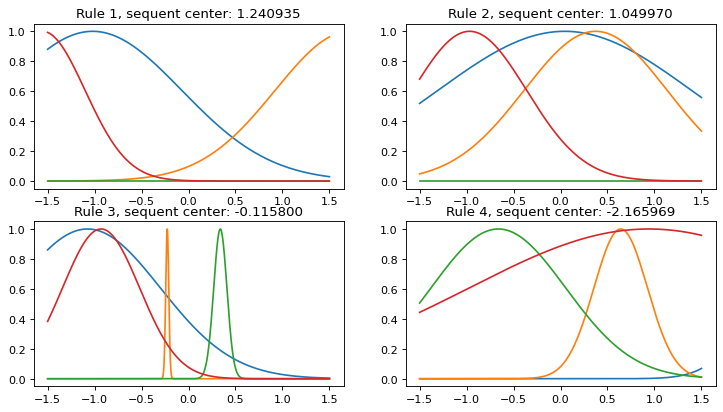

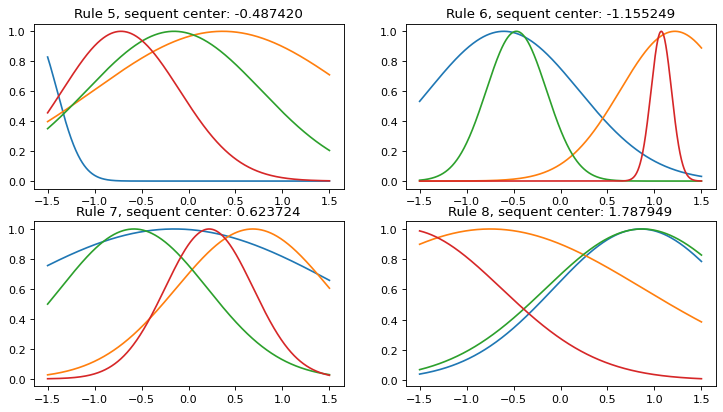

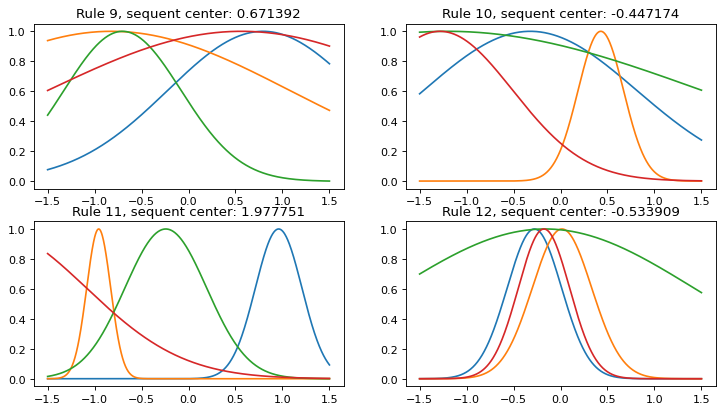

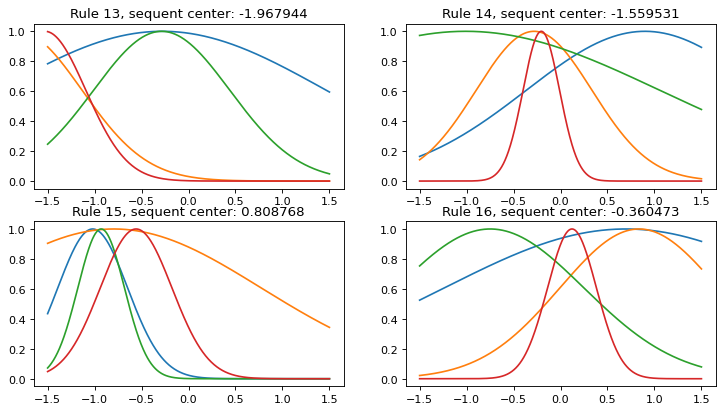

In [ ]:
# Training
num_epochs = 100
# Initialize session to make computations on the Tensorflow graph
with tf.Session() as sess:
    # Initialize model parameters
    sess.run(fis.init_variables)
    trn_costs = []
    val_costs = []
    time_start = time.time()
    for epoch in range(num_epochs):
        #  Run an update step
        trn_loss, trn_pred = fis.train(sess, trnData, trnLbls)
        # Evaluate on validation set
        val_pred, val_loss = fis.infer(sess, chkData, chkLbls)
        if epoch % 10 == 0:
            print("Train cost after epoch %i: %f" % (epoch, trn_loss))
        if epoch == num_epochs - 1:
            time_end = time.time()
            print("Elapsed time: %f" % (time_end - time_start))
            print("Validation loss: %f" % val_loss)
            # Plot real vs. predicted
            pred = np.vstack((np.expand_dims(trn_pred, 1), np.expand_dims(val_pred, 1)))
            plt.figure(1)
            plt.plot(mg_series)
            plt.plot(pred)
        trn_costs.append(trn_loss)
        val_costs.append(val_loss)
    # Plot the cost over epochs
    plt.figure(2)
    plt.subplot(2, 1, 1)
    plt.plot(np.squeeze(trn_costs))
    plt.title("Training loss, Learning rate =" + str(alpha))
    plt.subplot(2, 1, 2)
    plt.plot(np.squeeze(val_costs))
    plt.title("Validation loss, Learning rate =" + str(alpha))
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    # Plot resulting membership functions
    fis.plotmfs(sess)
    plt.show()

In [ ]:
!git push .

Everything up-to-date


In [ ]:
%%writefile   ANFIS.ipynb
print('my new notebook')

Overwriting ANFIS.ipynb


In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	new file:   ANFIS2.ipynb
	new file:   __pycache__/anfis.cpython-37.pyc

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ANFIS.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	TensorANFIS/



In [ ]:
!git commit . 

hint: Waiting for your editor to close the file... error: unable to start editor 'editor'
Please supply the message using either -m or -F option.


In [ ]:
!git push /content/TensorANFIS

Everything up-to-date
